In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import time
plt.style.use("bmh")

In [2]:
def LH(q, alpha=0.925, reflect=30):
    def first_pass(q, a) -> pd.DataFrame:
        b = 0.5 * (1 + a)
        qf = np.zeros(len(q))  # Empty quickflow
        qf[0] = q[0]
        for i in range(1, len(qf)):
            qf[i] = a * qf[i - 1] + b * (q[i] - q[i - 1])
        qb1 = np.where(qf > 0, q - qf, q)
        return pd.DataFrame({"qf": qf, "qb": qb1})
    def backwards_pass(q, a) -> pd.DataFrame:
        n = len(q["qb"])
        qb = q["qb"]
        b = 0.5 * (1 + a)
        qf = np.zeros(n)  # Empty array
        qf[-1] = qb.iloc[-1]
        for i in range(n - 2, 0, -1):
            qf[i] = a * qf[i + 1] + b * (qb.iloc[i] - qb.iloc[i + 1])
        qb2 = np.where(qf > 0, qb - qf, qb)
        return pd.DataFrame({"qf": qf, "qb": qb2})
    def forward_pass(q, a) -> pd.DataFrame:
        n = len(q["qb"])
        qb = q["qb"]
        b = 0.5 * (1 + a)
        qf = np.zeros(n)  # Empty array
        qf[0] = qb.iloc[0]
        for i in range(1, n):
            qf[i] = a * qf[i - 1] + b * (qb.iloc[i] - qb.iloc[i - 1])
        qb2 = np.where(qf > 0, qb - qf, qb)
        return pd.DataFrame({"qf": qf, "qb": qb2})
    q_in = np.pad(q, (reflect, reflect), mode="reflect")  # Pad the dataset
    df_tmp = first_pass(q_in, alpha)
    df_tmp = backwards_pass(df_tmp, alpha)
    df_tmp = forward_pass(df_tmp, alpha)
    qb = df_tmp["qb"][reflect:-reflect].to_numpy()
    qb[qb < 0] = 0                  # Set values less than zero to zero
    return qb


In [3]:
def read(full_path):
    nan_list = []
    file_object = open(full_path, "r")
    file_object.readline()
    for line in file_object:
        if line[:2] == "#*":
            df = pd.read_csv(file_object, delim_whitespace=True, header=0, index_col=[0, 1, 2])
            break
        nan_list.append(eval(line[2:]))
    file_object.close()
    return nan_list, df


In [8]:
filepath = "../GEO3000/code/data/discharge_data_100_cleaned/"
# files = [
#     "12.209",
#     "88.4",
#     "105.1",
#     "12.178",
#     "35.16",
#     "78.8",
#     "124.2",
#     "212.10",
#     "26.29",
#     "109.42",
#     "311.460"
# ]
files = ["15.21"]
ftype = ".q"
# _, df = read(filepath + file + ftype)
# q = df["discharge"].to_numpy()


In [9]:
def wallingford(q, beta):
    n = len(q)
    if n%5 != 0:
        nm = n - n%5
    else: nm =  n
    
    qb = np.zeros(n)
    
    minimas = []
    c = 0 
    while c < n:
        x = q[c:c+5]
        idxm = x.argmin()
        minimas.append((idxm + c, x[idxm]))
        c += 5
        
    c = 1
    t = []
    while c < len(minimas) - 1:
        if minimas[c][1]*beta <= np.min((minimas[c-1][1], minimas[c+1][1])):
            t.append(minimas[c])

        c += 1
    ip = 0
    jp = t[0][1]
    for i,j in t:
        
        l = i - ip
        x = np.linspace(0, l - 1, l)
        a = (j-jp)/(i - ip)
        f = lambda x: a*x + jp
        
        qb[ip:i] = f(x)
        ip = i
        jp = j
#     print(minimas[-20:])
#     print(t[-10:])
    qb[ip:] = jp
    
    qb = np.where(qb > q, q, qb)
    return qb

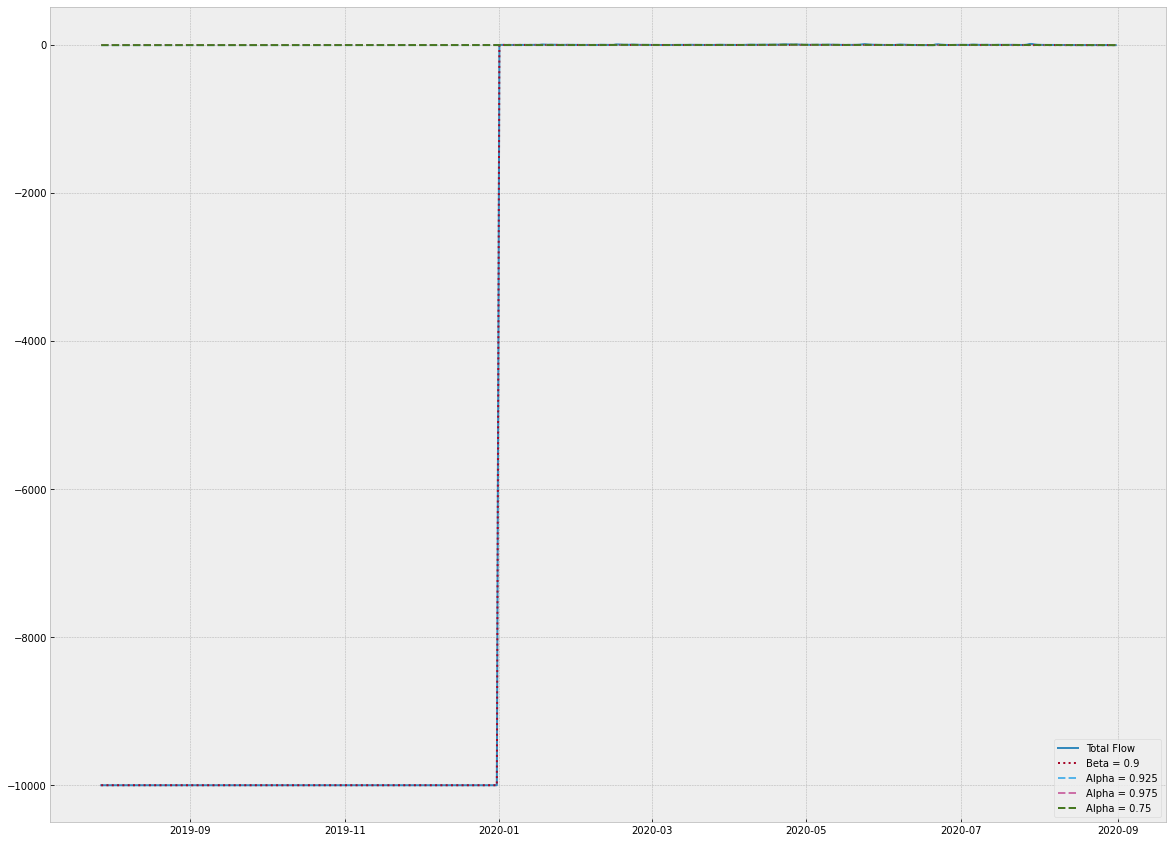

Total time used: 0:00:00.616118


In [15]:
alphas = [0.925, 0.975, 0.75]
lh_alpha = {}
betas = [0.9]
w_beta = {}
# indexing = {
#     "2.634": 0,
#     "2.265": 1,
# }

# files = ["311.460", "311.460"]

color_pallette = {
    "total": '#348ABD',
    0.9: '#A60628',
    0.925: '#56B4E9',
    0.95: '#009E73',
    0.95: '#009E73',
    0.8: '#CC70A7',
    0.975: '#CC70A7',
    0.75: '#467821'
}

length = int(np.floor(365*1.1))


indexing = dict(map(lambda t: (t[1], t[0]), enumerate(files)))

fs = len(files)
fig, ax = plt.subplots(fs,1, figsize=(20,15*fs))


start_time1 = time.time()
for file in files:
    _, df = read(filepath + file + ftype)
    q = df["discharge"].to_numpy()

    x = df.index[-length:].to_numpy()
    
    for i in range(len(x)):
        x[i] = datetime.datetime(x[i][0],x[i][1],x[i][2])
#     x = np.linspace(0,length, length)
    for alpha in alphas:
        lh_alpha[alpha] = LH(q, alpha = alpha)
    for beta in betas:
        w_beta[beta] = wallingford(q, beta = beta)
    if not fs == 1:
        ax[indexing[file]].set(
            title=f"LH separation - {file}",
    #         xlabel="Days",
            ylabel="discharge [V/t]"
        )
    
        ax[indexing[file]].plot(x, q[-length:], label="Total Flow",color=color_pallette["total"])

        for key in betas:
            ax[indexing[file]].plot(x, w_beta[key][-length:], label=f"Beta = {key}", linestyle=":", color=color_pallette[key])
        for key in alphas:
            ax[indexing[file]].plot(x, lh_alpha[key][-length:], label=f"Alpha = {key}", linestyle="--",color=color_pallette[key])
        ax[indexing[file]].legend()
    else:
        ax.plot(x, q[-length:], label="Total Flow",color=color_pallette["total"])
        for key in betas:
            ax.plot(x, w_beta[key][-length:], label=f"Beta = {key}", linestyle=":", color=color_pallette[key])
        for key in alphas:
            ax.plot(x, lh_alpha[key][-length:], label=f"Alpha = {key}", linestyle="--",color=color_pallette[key])
        ax.legend()
#     import matplotlib.ticker as plticker
#     loc = plticker.MultipleLocator(base=1)
#     ax[indexing[file]].xaxis.set_major_locator(loc)
#     print(len(w_beta[beta]))
plt.show()
print("Total time used: " + str(datetime.timedelta(seconds=time.time() - start_time1)))